This model uses a more robust SimpleLSTM in a Sequence-to-Sequence (Seq2Seq) framework. Its function is to predict an entire future sequence (e.g., the next 3 hours) in a single, direct pass. It is trained to take an input sequence and output a full sequence of future predictions, making it more stable for multi-step forecasting as it doesn't use its own predictions as input. This model uses 6 input features, explicitly removing the 'bolus' feature.

In [ ]:
import os
import zipfile
import torch
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
# This will prompt you for authorization.
drive.mount('/content/drive')

# --- Configuration ---
# IMPORTANT: Verify this path matches your project folder in Google Drive.
# It should contain the 'Ohio Data.zip' file.
HOME_DIR = 'drive/MyDrive/vinay_glucose'
os.chdir(HOME_DIR)

DATA_PATH = './Ohio Data'
ZIP_PATH = './Ohio Data.zip'

# --- Unzip Data if not already extracted ---
if not os.path.exists(DATA_PATH):
    print("Extracting data from 'Ohio Data.zip'...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('.') # Extract to the current directory (HOME_DIR)
    print("Data extracted successfully.")
else:
    print("Data directory already exists. Skipping extraction.")

# --- Define Data Directories ---
train_data_dirs = [
    f"{DATA_PATH}/Ohio2018_processed/train",
    f"{DATA_PATH}/Ohio2020_processed/train"
]
test_data_dirs = [
    f"{DATA_PATH}/Ohio2018_processed/test",
    f"{DATA_PATH}/Ohio2020_processed/test"
]

print(f"Working Directory: {os.getcwd()}")
print("Setup complete.")

Mounted at /content/drive
Data directory already exists. Skipping extraction.
Working Directory: /content/drive/MyDrive/vinay_glucose
Setup complete.


In [ ]:
def get_scaler(data_df):
    """Creates a scaler and fill values for a combined dataframe."""
    data_df1 = data_df.copy()

    # MODIFIED: Remove the insulin 'bolus' column if it exists
    if 'bolus' in data_df1.columns:
        data_df1 = data_df1.drop(columns=['bolus'])

    # Interpolate missing cbg values
    missing_cbg_indices = data_df1[data_df1['missing_cbg'] == 1].index
    known_indices = data_df1.index[~data_df1.index.isin(missing_cbg_indices)]

    if len(known_indices) > 3 and len(missing_cbg_indices) > 0:
        cs = CubicSpline(known_indices, data_df1.loc[known_indices, 'cbg'])
        data_df1.loc[missing_cbg_indices, 'cbg'] = cs(missing_cbg_indices)

    # Drop timestamp and flags, then move cbg to the end
    if 'index' in data_df1.columns:
        data_df1 = data_df1.drop(columns=['index'])
    data_df1 = data_df1.drop(columns=['5minute_intervals_timestamp', 'missing_cbg'])
    if 'cbg' in data_df1.columns:
        cbg = data_df1.pop('cbg')
        data_df1 = data_df1.assign(cbg=cbg)

    # Calculate fill values for any other missing data
    column_mins = data_df1.min()
    fill_values = column_mins - 0.01 * np.abs(column_mins)
    data_df2 = data_df1.fillna(fill_values)

    # Fit the scaler
    scaler = MinMaxScaler()
    scaler.fit(data_df2)

    return scaler, fill_values.values, data_df2.columns


class OhioT1DMDataset(Dataset):
    """Custom PyTorch Dataset for the Ohio T1DM data."""
    def __init__(self, data_dirs, seq_length):
        self.seq_length = seq_length
        dataframes = []
        for data_dir in data_dirs:
            for file in os.listdir(data_dir):
                file_path = os.path.join(data_dir, file)
                data_df = pd.read_csv(file_path)
                dataframes.append(data_df)

        merged_data = pd.concat(dataframes).reset_index()
        self.scaler, self.fill_values, self.columns = get_scaler(merged_data)
        self.processed_dfs = [self.preprocess(df) for df in dataframes]
        self.data = [torch.tensor(df.values, dtype=torch.float32) for df in self.processed_dfs]

    def preprocess(self, data_df):
        data_df1 = data_df.copy()

        # MODIFIED: Remove the insulin 'bolus' column if it exists
        if 'bolus' in data_df1.columns:
            data_df1 = data_df1.drop(columns=['bolus'])

        missing_cbg_indices = data_df1[data_df1['missing_cbg'] == 1].index
        known_indices = data_df1.index[~data_df1.index.isin(missing_cbg_indices)]
        if len(known_indices) > 3 and len(missing_cbg_indices) > 0:
            cs = CubicSpline(known_indices, data_df1.loc[known_indices, 'cbg'])
            data_df1.loc[missing_cbg_indices, 'cbg'] = cs(missing_cbg_indices)

        if 'index' in data_df1.columns:
            data_df1 = data_df1.drop(columns=['index'])
        data_df1 = data_df1.drop(columns=['5minute_intervals_timestamp', 'missing_cbg'])
        if 'cbg' in data_df1.columns:
            cbg = data_df1.pop('cbg')
            data_df1 = data_df1.assign(cbg=cbg)

        data_df1 = data_df1[self.columns] # Reorder columns to match scaler
        values = np.where(np.isnan(data_df1.values), self.fill_values, data_df1.values)
        scaled_values = self.scaler.transform(values)
        return pd.DataFrame(scaled_values, columns=self.columns)

    def __len__(self):
        return sum(max(0, len(data) - self.seq_length) for data in self.data)

    def __getitem__(self, index):
        data_idx = 0
        while index >= max(0, len(self.data[data_idx]) - self.seq_length):
            index -= max(0, len(self.data[data_idx]) - self.seq_length)
            data_idx += 1

        sequence = self.data[data_idx][index : index + self.seq_length + 1]
        inputs = sequence[:-1, :]
        target = sequence[1:, :]
        return inputs, target

In [ ]:
def create_dataloader(data_dirs, seq_length, batch_size, shuffle=True):
    """Creates a PyTorch DataLoader."""
    dataset = OhioT1DMDataset(data_dirs, seq_length)
    # Use multiple workers to speed up data loading
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)
    return dataloader

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.4)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

In [ ]:
def train(model, train_dataloader, test_dataloader, num_epochs, lr, device, checkpoint_path='training_checkpoint.pth'):
    """
    MODIFIED function to train the model with checkpointing for resuming.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

    # --- Load state from checkpoint if it exists ---
    start_epoch = 0
    best_validation_loss = float('inf')
    if os.path.exists(checkpoint_path):
        print(f"Checkpoint found at '{checkpoint_path}'. Resuming training.")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_validation_loss = checkpoint.get('best_validation_loss', float('inf'))
        print(f"Resumed from Epoch {start_epoch + 1}. Best validation loss so far: {best_validation_loss:.6f}")
    else:
        print("No checkpoint found. Starting training from scratch.")

    print("Starting training...")
    # --- The loop now starts from the last saved epoch ---
    for epoch in range(start_epoch, num_epochs):
        print(f"--- Epoch {epoch+1}/{num_epochs} ---")
        model.train()
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # --- Validation phase ---
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.6f}')
        scheduler.step(avg_val_loss)

        # --- Save the best model (your original logic) ---
        if avg_val_loss < best_validation_loss:
            best_validation_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with validation loss: {avg_val_loss:.6f}')

        # --- Save checkpoint after every epoch ---
        torch.save({
            'epoch': epoch + 1, # Save the *next* epoch number to start from
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_validation_loss': best_validation_loss,
        }, checkpoint_path)

    print('Training complete.')
    return model

In [ ]:
# --- Model Hyperparameters ---
SEQ_LENGTH = 36      # Look at 3 hours of data (36 * 5 minutes)
BATCH_SIZE = 512     # Increase if your GPU can handle it
NUM_EPOCHS = 150     # Total epochs to train for
LEARNING_RATE = 0.001

# --- Checkpointing ---
# This file will be saved in your HOME_DIR to store progress
CHECKPOINT_PATH = "training_checkpoint.pth"

# --- Create Dataloaders ---
print("Creating DataLoaders...")
train_loader = create_dataloader(train_data_dirs, seq_length=SEQ_LENGTH, batch_size=BATCH_SIZE)
test_loader = create_dataloader(test_data_dirs, seq_length=SEQ_LENGTH, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoaders created.")

# Determine the number of features from the data
num_features = len(train_loader.dataset.columns)
print(f"Number of features detected: {num_features}")

# --- Architecture Hyperparameters ---
INPUT_SIZE = num_features
HIDDEN_SIZE = 128
NUM_LAYERS = 3
OUTPUT_SIZE = num_features

# --- Initialize Model and Device ---
# IMPORTANT: Ensure your Colab runtime is set to GPU (Runtime -> Change runtime type)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = SimpleLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
print(f"Model initialized on device: {device}")

# --- Start or Resume Training ---
trained_model = train(
    model=lstm_model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    num_epochs=NUM_EPOCHS,
    lr=LEARNING_RATE,
    device=device,
    checkpoint_path=CHECKPOINT_PATH
)

Creating DataLoaders...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

DataLoaders created.
Number of features detected: 6
Model initialized on device: cuda
Checkpoint found at 'training_checkpoint.pth'. Resuming training.
Resumed from Epoch 151. Best validation loss so far: 0.001381
Starting training...
Training complete.


In [ ]:
def compute_and_display_metrics(model, dataloader, device):
    """Calculates and displays performance metrics for glucose."""
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)[:, -1, :]
            target = targets[:, -1, :]
            all_preds.append(output.cpu())
            all_targets.append(target.cpu())

    preds_scaled = torch.cat(all_preds, dim=0).numpy()
    targets_scaled = torch.cat(all_targets, dim=0).numpy()

    scaler = dataloader.dataset.scaler
    preds_unscaled = scaler.inverse_transform(preds_scaled)
    targets_unscaled = scaler.inverse_transform(targets_scaled)

    columns = list(dataloader.dataset.columns)
    cbg_idx = columns.index('cbg')

    cbg_rmse = np.sqrt(mean_squared_error(targets_unscaled[:, cbg_idx], preds_unscaled[:, cbg_idx]))
    cbg_mae = mean_absolute_error(targets_unscaled[:, cbg_idx], preds_unscaled[:, cbg_idx])

    print("\n" + "="*40)
    print(" Model Performance Metrics (Test Set)")
    print("="*40)
    print(f"Metric      | Glucose (mg/dL)")
    print("-"*40)
    print(f"RMSE        | {cbg_rmse:<15.2f}")
    print(f"MAE         | {cbg_mae:<15.2f}")
    print("="*40)


# --- Load the Best Trained Model ---
print("Loading the best model for final evaluation...")
final_model = SimpleLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
final_model.load_state_dict(torch.load('best_model.pth'))

# --- Create a Test Dataloader for Analysis ---
analysis_loader = create_dataloader(test_data_dirs, seq_length=SEQ_LENGTH, batch_size=BATCH_SIZE, shuffle=False)

# --- Compute and Display Metrics ---
compute_and_display_metrics(final_model, analysis_loader, device)

Loading the best model for final evaluation...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida


 Model Performance Metrics (Test Set)
Metric      | Glucose (mg/dL)
----------------------------------------
RMSE        | 17.50          
MAE         | 12.35          



Generating detailed analysis plots for a random sample...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

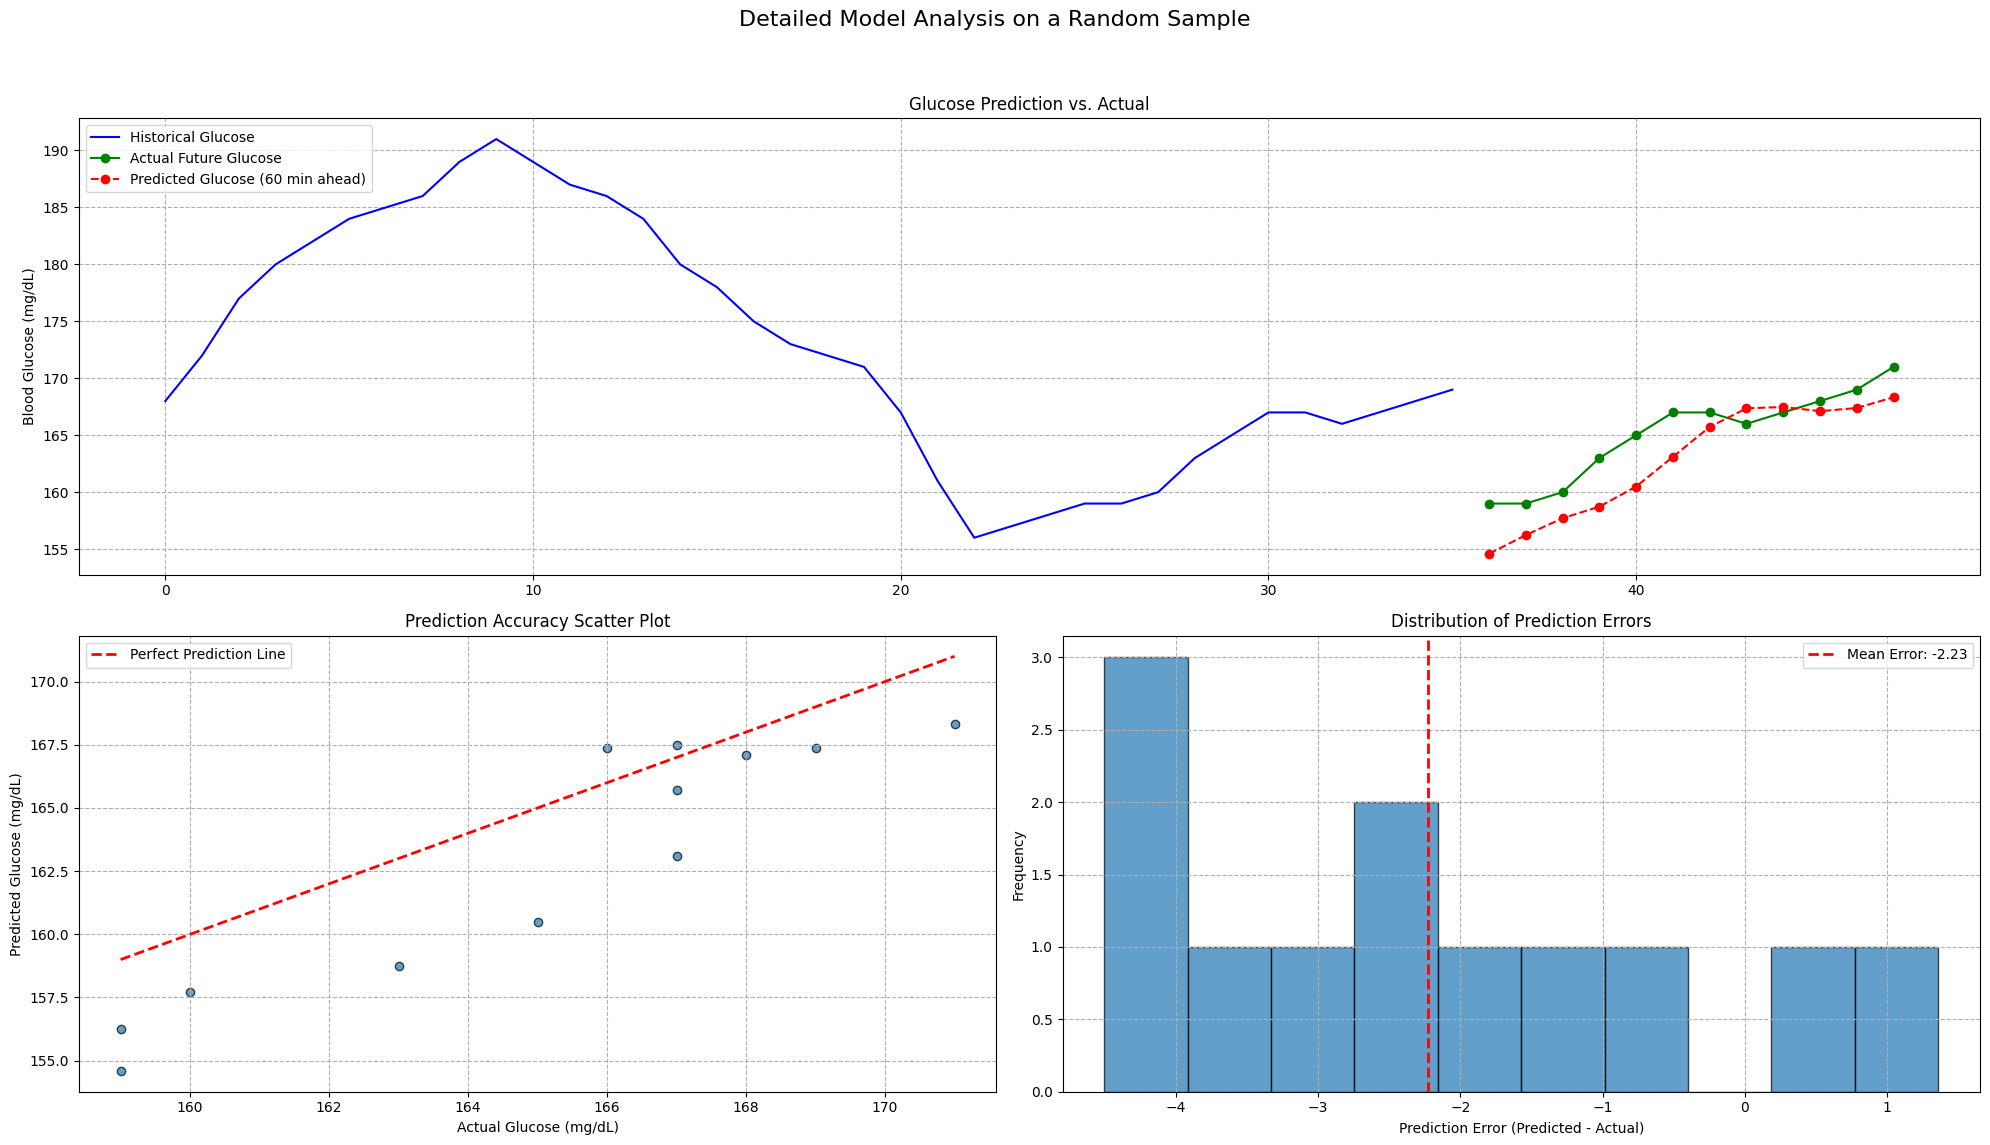

In [ ]:
def plot_detailed_analysis(model, dataloader, device, n_steps_ahead=12):
    """Generates a more detailed plot including prediction, scatter, and error distribution."""
    model.eval()
    inputs, actual_sequences = next(iter(dataloader))
    sample_input = inputs[:1].to(device)
    actual_sequence = actual_sequences[:1].to(device)

    # --- Autoregressive prediction ---
    with torch.no_grad():
        full_prediction = model(sample_input)
        # We take the predictions for the last n_steps_ahead from the output sequence
        last_step_predictions = full_prediction[:, -n_steps_ahead:, :]

    # --- Prepare data for plotting ---
    scaler = dataloader.dataset.scaler
    columns = list(dataloader.dataset.columns)
    cbg_idx = columns.index('cbg')

    context_unscaled = scaler.inverse_transform(sample_input.squeeze(0).cpu().numpy())
    predicted_steps_unscaled = scaler.inverse_transform(last_step_predictions.squeeze(0).cpu().numpy())
    true_future_unscaled = scaler.inverse_transform(actual_sequence.squeeze(0).cpu().numpy())[-n_steps_ahead:]

    context_glucose = context_unscaled[:, cbg_idx]
    predicted_glucose = predicted_steps_unscaled[:, cbg_idx]
    true_glucose = true_future_unscaled[:, cbg_idx]

    # --- Create the plots ---
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 2)
    fig.suptitle('Detailed Model Analysis on a Random Sample', fontsize=16)

    # Plot 1: Main Prediction Plot
    ax1 = fig.add_subplot(gs[0, :])
    time_steps_context = np.arange(len(context_glucose))
    time_steps_pred = np.arange(len(context_glucose), len(context_glucose) + n_steps_ahead)

    ax1.plot(time_steps_context, context_glucose, 'b-', label='Historical Glucose')
    ax1.plot(time_steps_pred, true_glucose, 'g-o', label='Actual Future Glucose')
    ax1.plot(time_steps_pred, predicted_glucose, 'r--o', label=f'Predicted Glucose ({n_steps_ahead*5} min ahead)')
    ax1.set_ylabel('Blood Glucose (mg/dL)')
    ax1.set_title('Glucose Prediction vs. Actual')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--')

    # Plot 2: Scatter Plot
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(true_glucose, predicted_glucose, alpha=0.7, edgecolors='k')
    ax2.plot([min(true_glucose), max(true_glucose)], [min(true_glucose), max(true_glucose)], 'r--', lw=2, label='Perfect Prediction Line')
    ax2.set_xlabel('Actual Glucose (mg/dL)')
    ax2.set_ylabel('Predicted Glucose (mg/dL)')
    ax2.set_title('Prediction Accuracy Scatter Plot')
    ax2.legend()
    ax2.grid(True, linestyle='--')

    # Plot 3: Error Distribution
    ax3 = fig.add_subplot(gs[1, 1])
    errors = predicted_glucose - true_glucose
    ax3.hist(errors, bins=10, edgecolor='k', alpha=0.7)
    ax3.axvline(errors.mean(), color='r', linestyle='--', lw=2, label=f'Mean Error: {errors.mean():.2f}')
    ax3.set_xlabel('Prediction Error (Predicted - Actual)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Prediction Errors')
    ax3.legend()
    ax3.grid(True, linestyle='--')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Create a loader for visualization with a batch size of 1 ---
vis_loader = create_dataloader(test_data_dirs, seq_length=SEQ_LENGTH, batch_size=1, shuffle=True)

print("\nGenerating detailed analysis plots for a random sample...")
plot_detailed_analysis(final_model, vis_loader, device)